# **Setup**

In [9]:
import pandas as pd
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from string import punctuation
punctuation = list(punctuation)
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
lemmatizer = WordNetLemmatizer()
from wordcloud import WordCloud
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

# **Vertuo**
Example Coffee: Intenso

## Data Preparation

In [2]:
dfVertuo_Raw = pd.read_excel("CoffeeData.xlsx", index_col=False, sheet_name="Vertuo");
print(dfVertuo_Raw.columns)
dfVertuo_Raw[0:1]

Index(['ID', 'Name', 'Type', 'Serving', 'Serving Size', 'Headline',
       'Intensity', 'Sleeve Price', 'Per Capsule Price', 'Caption', 'Taste',
       'Best Served As', 'Notes', 'Acidity', 'Bitterness', 'Roastness', 'Body',
       'Milky Taste', 'Bitterness with Milk', 'Roastiness with Milk',
       'Creamy Texture', 'Ingredients & Allergens',
       'Number of Capsules per Sleeve',
       'Net Weight per Total Number of Capsules', 'Capsule Image Link',
       'Capsule & Sleeve Image Link', 'Decaf Coffee?', 'Category',
       'Other Information'],
      dtype='object')


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Roastiness with Milk,Creamy Texture,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information
0,VL01,Intenso,Vertuo,Coffee,230ml,Smooth & Strong,9.0,12.6,1.26,Why we love it: Try Intenso - a Vertuo coffee ...,...,NaN,NaN,Roast and ground coffee,10,125 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Signature Coffee,NaN


In [3]:
def process_text_for_NLP_Vertuo(df_Raw):
    # Columns used for NLP:
    # NLPColumns_Vertuo = ["Type","Serving","Headline","Caption","Taste","Best Served As","Notes","Ingredients & Allergens","Category"];
    NLPColumns_Vertuo = ["Serving","Headline","Caption","Taste","Best Served As","Notes","Category"];

    # NLP Pre-Processing:
    df_Prep = df_Raw.copy();
    df_Prep["Textual Info"] = "";
    for i in df_Prep.index:
        textualInfo = "";
        for col in NLPColumns_Vertuo:
            textualInfo += str(df_Prep.loc[i, col]).lower() + " ";
        textualInfo = textualInfo[:-1];
        textualInfo_tokens = word_tokenize(textualInfo);
        textualInfo_cleanedTokens = [];
        for token in textualInfo_tokens:
            token = lemmatizer.lemmatize(token, pos="a");
            if (token not in stop_words) and (token not in punctuation):
                token = re.sub(r'[^\w\s]', '', token);
                if token != '':
                    textualInfo_cleanedTokens.append(token);
        textualInfo_final = "";
        for token in textualInfo_cleanedTokens:
            textualInfo_final += token + " ";
        textualInfo_final = textualInfo_final[:-1];
        df_Prep.loc[i, "Textual Info"] = textualInfo_final;
    
    return df_Prep;

dfVertuo_Prep = process_text_for_NLP_Vertuo(dfVertuo_Raw);
print(dfVertuo_Prep.loc[0, "Textual Info"]);
dfVertuo_Prep[0:1]

coffee smooth strong love try intenso vertuo coffee dense dark night glowing golden brown sugar notes blend guatemalan washed robusta coffee beans latin american arabica thick roasted notes lingering finish split roast nespresso intenso blend arabicas get dark roast low acidity bring brown sugar aroma guatemalan coffee gets long roast develop robusta coffee beans bold bitter notes intense long black distinctly lingering aftertaste thick coffee crema coffee 230ml intense signature coffee


,ID,Name,Type,Serving,Serving Size,Headline,Intensity,Sleeve Price,Per Capsule Price,Caption,...,Creamy Texture,Ingredients & Allergens,Number of Capsules per Sleeve,Net Weight per Total Number of Capsules,Capsule Image Link,Capsule & Sleeve Image Link,Decaf Coffee?,Category,Other Information,Textual Info
0,VL01,Intenso,Vertuo,Coffee,230ml,Smooth & Strong,9.0,12.6,1.26,Why we love it: Try Intenso - a Vertuo coffee ...,...,NaN,Roast and ground coffee,10,125 g,https://www.nespresso.com/ecom/medias/sys_mast...,https://www.nespresso.com/shared_res/agility/n...,No,Signature Coffee,NaN,coffee smooth strong love try intenso vertuo c...


## Natural Language Processing

### ***Wordcloud***
Example Coffee: Intenso

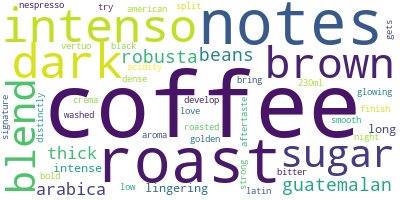

In [4]:
def get_wordcloud_Vertuo(df_Prep, coffee_select):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color="steelblue");
    mask = df_Prep["Name"] == coffee_select;
    idx = df_Prep.index[mask].tolist()[0];
    wc = wordcloud.generate(df_Prep.loc[idx, "Textual Info"]);
    return wc.to_image();

df_Prep = dfVertuo_Prep;
coffee_select = "Intenso";

get_wordcloud_Vertuo(df_Prep, coffee_select)

### ***Named Entity Recognition (NER)***
Example Coffee: Odacio

In [10]:
def get_NER_Vertuo(df_Prep, coffee_select):
    mask = df_Prep["Name"] == coffee_select;
    idx = df_Prep.index[mask].tolist()[0];

    # nlp = spacy.load("en_core_web_sm");
    doc = nlp(df_Prep.loc[idx, "Textual Info"]);

    data = [];
    for token in doc:
        row = [token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop];
        data.append(row);
    df_NER = pd.DataFrame(data, columns=["TEXT","LEMMA","POS","TAG","DEP","SHAPE","ALPHA","STOP"]);
    return df_NER;

df_Prep = dfVertuo_Prep;
coffee_select = "Odacio";

# Column definitions:
# Text: The original word text.
# Lemma: The base form of the word.
# POS: The simple UPOS part-of-speech tag.
# Tag: The detailed part-of-speech tag.
# Dep: Syntactic dependency, i.e. the relation between tokens.
# Shape: The word shape – capitalization, punctuation, digits.
# is alpha: Is the token an alpha character?
# is stop: Is the token part of a stop list, i.e. the most common words of the language?

get_NER_Vertuo(df_Prep, coffee_select)

,TEXT,LEMMA,POS,TAG,DEP,SHAPE,ALPHA,STOP
0,coffee,coffee,NOUN,NN,nmod,xxxx,True,False
1,bold,bold,ADJ,JJ,amod,xxxx,True,False
2,lively,lively,ADJ,JJ,amod,xxxx,True,False
3,love,love,NOUN,NN,nsubj,xxxx,True,False
4,odacio,odacio,X,FW,ccomp,xxxx,True,False
...,...,...,...,...,...,...,...,...
61,elegance,elegance,NOUN,NN,dobj,xxxx,True,False
62,nan,nan,PROPN,NNP,nmod,xxx,True,False
63,intense,intense,ADJ,JJ,amod,xxxx,True,False
64,signature,signature,NOUN,NN,compound,xxxx,True,False


### ***Term Frequency-Inverse Document Frequency (TF-IDF)***
Example Coffee: Melozio

In [13]:
def get_dataframeNLP_Vertuo(df_Prep, coffee_select):
    df_coffeeSelect = df_Prep[df_Prep["Name"] == coffee_select];
    df_NLP = pd.concat([df_coffeeSelect, df_Prep]);
    df_NLP = df_NLP.drop_duplicates();
    df_NLP = df_NLP[df_NLP.columns.tolist()[1:]];
    df_NLP = df_NLP.reset_index();
    return df_NLP;

def get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim):
    idx = indices[coffee_select];
    sim_scores = list(enumerate(cosine_sim[idx]));
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True);
    sim_scores = sim_scores[1:numRec+1];
    coffee_indices = [i[0] for i in sim_scores];
    df_Rec = df_NLP[["Name","Serving","Headline","Intensity","Category"]].iloc[coffee_indices];
    
    similarityScores = [];
    for i in range(len(sim_scores)):
        similarityScores.append(round(sim_scores[i][1], 4));
    df_Rec["Similarity Score"] =  similarityScores;
    
    df_Rec = df_Rec.reset_index().rename(columns={"index":"id"});
    
    return df_Rec;

def get_recommendationResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
        
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, sublinear_tf=sublinear_tf);
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    cosine_sim = linear_kernel(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim);
    
    return df_Rec;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Melozio";
numRec = 10;
min_df = 2;
max_df = 0.95;
max_features = 50;
stop_words = "english";
# Unique Parameters:
sublinear_tf = True;

get_recommendationResultsTFIDF_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, sublinear_tf)

,id,Name,Serving,Headline,Intensity,Category,Similarity Score
0,5,Melozio Decaffeinato,Coffee,Smooth & Balanced,6.0,Signature Coffee,0.9007
1,26,Carafe Pour-Over Style Mild,Carafe,Toasted Cereal & Malted,NaN,Craft Brew,0.5579
2,24,Double Espresso Dolce,Double Espresso,Cereal & Mild,5.0,Double Espresso,0.4847
3,6,Half Caffeinato,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.4691
4,17,Diavolitto,Espresso,Highly Intense & Powerful,11.0,Espresso,0.4586
5,2,Stormio,Coffee,Rich & Strong,8.0,Signature Coffee,0.4150
6,29,Bianco Forte,Coffee,Full & Balanced; For Intense Recipes With Milk,NaN,Barista Creations,0.4045
7,30,Vanilla Custard Pie,Coffee,Sweet & Velvety; Vanilla Flavoured,NaN,Barista Creations,0.4038
8,20,Altissio,Espresso,Full-Bodied & Creamy,9.0,Espresso,0.3881
9,25,Voltesso,Espresso,Light & Sweet,4.0,Espresso,0.3879


### ***Bag of Words***
Example Coffee: Stormio

In [12]:
def get_recommendationResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper):
    df_NLP = get_dataframeNLP_Vertuo(df_Prep, coffee_select);
    
    # vectorizer = CountVectorizer(analyzer='word', token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    vectorizer = CountVectorizer(min_df=min_df, max_df=max_df, max_features=max_features, stop_words=stop_words, analyzer=analyzer, token_pattern=token_pattern, ngram_range=(n_lower, n_upper));
    matrix = vectorizer.fit_transform(df_NLP["Textual Info"]);
    cosine_sim = cosine_similarity(matrix, matrix);
    indices = pd.Series(df_NLP.index, index=df_NLP["Name"]).drop_duplicates();
    
    df_Rec = get_recommendations_Vertuo(df_NLP, coffee_select, numRec, indices, cosine_sim);
    
    return df_Rec;

# General Parameters:
df_Prep = dfVertuo_Prep;
coffee_select = "Stormio";
numRec = 10;
min_df = 5;
max_df = 0.95;
max_features = 50;
stop_words = "english";
# Unique Parameters:
analyzer = "word";
token_pattern = r"\b[a-zA-Z]{3,}\b";
n_lower = 1;
n_upper = 1;

get_recommendationResultsBagOfWords_Vertuo(df_Prep, coffee_select, numRec, min_df, max_df, max_features, stop_words, analyzer, token_pattern, n_lower, n_upper)

,id,Name,Serving,Headline,Intensity,Category,Similarity Score
0,1,Intenso,Coffee,Smooth & Strong,9.0,Signature Coffee,0.6198
1,26,Carafe Pour-Over Style Mild,Carafe,Toasted Cereal & Malted,NaN,Craft Brew,0.6187
2,10,Odacio,Coffee,Bold & Lively,7.0,Signature Coffee,0.5995
3,9,Solelio,Coffee,Fruity & Lightly-Bodied,2.0,Signature Coffee,0.5522
4,29,Bianco Forte,Coffee,Full & Balanced; For Intense Recipes With Milk,NaN,Barista Creations,0.5512
5,22,Orafio,Espresso,Caramel & Roasted,6.0,Espresso,0.5148
6,6,Half Caffeinato,Coffee,Sweet & Velvety,5.0,Signature Coffee,0.5009
7,8,Inizio,Gran Lungo,Floral & Cereal,4.0,Gran Lungo,0.4939
8,16,Il Caffè,Espresso,Exceptionally Intense & Velvety,11.0,Espresso,0.4798
9,20,Altissio,Espresso,Full-Bodied & Creamy,9.0,Espresso,0.4521
